# Attention Model

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, Input, BatchNormalization, TimeDistributed, Attention, Bidirectional, Concatenate, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random as rn
import tensorflow as tf
import pickle
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
import os

Using TensorFlow backend.


## 1. Loading Data

In [ ]:
#loading data
x_train = pd.read_pickle('train_data.pickle')
y_train = pd.read_pickle('train_target.pickle')
x_test = pd.read_pickle('test_data.pickle')
y_test = pd.read_pickle('test_target.pickle')

### 1.1 Loading question vectorizer

In [ ]:
#loading the vecotirizer
que = pd.read_pickle('question_tokenizer.pickle')

In [ ]:
#converting the question data to integer
encoded_train = que.texts_to_sequences(x_train)
encoded_test = que.texts_to_sequences(x_test)
pad_train = pad_sequences(encoded_train, padding = 'post', maxlen = 36)
pad_test = pad_sequences(encoded_test, padding = 'post', maxlen = 36)

In [ ]:
question_vocab_size = len(que.word_index) + 1
print("size of vocabulary:",question_vocab_size)

size of vocabulary: 45136


### 1.2 Loading answer vectorizer

In [ ]:
#loading the vecotirizer
ans = pd.read_pickle('answer_tokenizer.pickle')

In [ ]:
#converting the answer data to integer
decoder_in_train = ans.texts_to_sequences(y_train['decoder_input'])
decoder_in_test = ans.texts_to_sequences(y_test['decoder_input'])
decoder_out_train = ans.texts_to_sequences(y_train['decoder_output']) 
decoder_out_test = ans.texts_to_sequences(y_test['decoder_output'])

decoder_in_train = pad_sequences(decoder_in_train, padding = 'post', maxlen = 15)
decoder_in_test = pad_sequences(decoder_in_test, padding = 'post', maxlen = 15)
decoder_out_train = pad_sequences(decoder_out_train, padding = 'post', maxlen = 15)
decoder_out_test = pad_sequences(decoder_out_test, padding = 'post', maxlen = 15)

In [ ]:
target_vocab_size = len(ans.word_index)+1
print('Size of Vocabulary:', target_vocab_size)

Size of Vocabulary: 33457


In [ ]:
ans_index_word = {}
ans_word_index = {}
for key,value in ans.word_index.items():
    ans_index_word[value] = key 
    ans_word_index[key] = value

In [ ]:
print(ans_index_word.get(1))
print(ans_index_word.get(2))

end
start


In [ ]:
#printing some data point
print(x_train.values[17])
print(pad_train[17])
print(y_train['decoder_input'].values[17])
print(decoder_in_train[17])
print(y_train['decoder_output'].values[17])
print(decoder_out_train[17])

turbo core work
[2952  794    7    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
<start> muy bien excelente compra
[   2 1937 2572 1983 8013    0    0    0    0    0    0    0    0    0
    0]
muy bien excelente compra <end>
[1937 2572 1983 8013    1    0    0    0    0    0    0    0    0    0
    0]


## 2. Model

In [ ]:
np.random.seed(42)
tf.random.set_seed(32)
rn.seed(12)

def get_attention_model():

    #encoder
    encoder_input = Input(shape = (pad_train.shape[1],), name = 'encoder_input')
    encoder_embedding_layer = Embedding(question_vocab_size, 32, mask_zero = True, name = 'encoder_embedding')
    encoder_embedding = encoder_embedding_layer(encoder_input)

    encoder_lstm = LSTM(32, return_state = True, activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                        recurrent_initializer=tf.keras.initializers.orthogonal(seed=54), bias_initializer="zeros", return_sequences = True, name = 'encoder_lstm')
    
    encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_state = [state_h, state_c]

    #decoder
    decoder_input = Input(shape = (None,), name = 'decoder_input')
    decoder_embedding_layer = Embedding(target_vocab_size, 32, mask_zero=True, name = 'decoder_embedding')
    decoder_embedding = decoder_embedding_layer(decoder_input)

    decoder_lstm = LSTM(32, return_sequences = True, return_state = True, activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),
                        recurrent_initializer=tf.keras.initializers.orthogonal(seed=54), bias_initializer="zeros", name = 'decoder_lstm')
    
    decoder_output, _, _= decoder_lstm(decoder_embedding, initial_state = encoder_state)


    #Attention layer
    attention_layer = Attention(name = 'attention_layer')
    attention_output = attention_layer([decoder_output, encoder_output])
    
    concat_layer = Concatenate(axis = -1)
    concat = concat_layer([decoder_output, attention_output])
    


    #output
    dense_layer = TimeDistributed(Dense(target_vocab_size, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45), name = 'dense_layer'))
    output = dense_layer(concat)

    model = Model([encoder_input, decoder_input], output)

    return model

In [ ]:
attention_model = get_attention_model()
attention_model.summary(line_length = 200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
encoder_input (InputLayer)                                        [(None, 36)]                                0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
decoder_input (InputLayer)                                        [(None, None)]                              0                                                                      

In [ ]:
log_path = os.path.join("logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path, histogram_freq=1) 

attention_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy')
attention_model.fit([pad_train, decoder_in_train], decoder_out_train, epochs = 25, batch_size = 128, validation_split = 0.1, callbacks = [tensorboard_callback])

Train on 125803 samples, validate on 13979 samples
Epoch 1/25
125803/125803 [==============================] - 198s 2ms/sample - loss: 2.8171 - val_loss: 2.6207
Epoch 2/25
125803/125803 [==============================] - 190s 2ms/sample - loss: 2.5295 - val_loss: 2.4578
Epoch 3/25
125803/125803 [==============================] - 193s 2ms/sample - loss: 2.3495 - val_loss: 2.3238
Epoch 4/25
125803/125803 [==============================] - 190s 2ms/sample - loss: 2.2324 - val_loss: 2.2481
Epoch 5/25
125803/125803 [==============================] - 191s 2ms/sample - loss: 2.1421 - val_loss: 2.1917
Epoch 6/25
125803/125803 [==============================] - 190s 2ms/sample - loss: 2.0680 - val_loss: 2.1542: 6s - - ETA: 3s - loss: 2 - ETA: 2
Epoch 7/25
125803/125803 [==============================] - 190s 2ms/sample - loss: 2.0072 - val_loss: 2.1274
Epoch 8/25
125803/125803 [==============================] - 190s 2ms/sample - loss: 1.9555 - val_loss: 2.1090
Epoch 9/25
125803/125803 [========

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 6396), started 0:01:00 ago. (Use '!kill 6396' to kill it.)

In [ ]:
attention_model.save('attention_weights.h5')

## 3. Inference 

In [3]:
attention_model = models.load_model('attention_weights.h5')

In [4]:
attention_model.layers

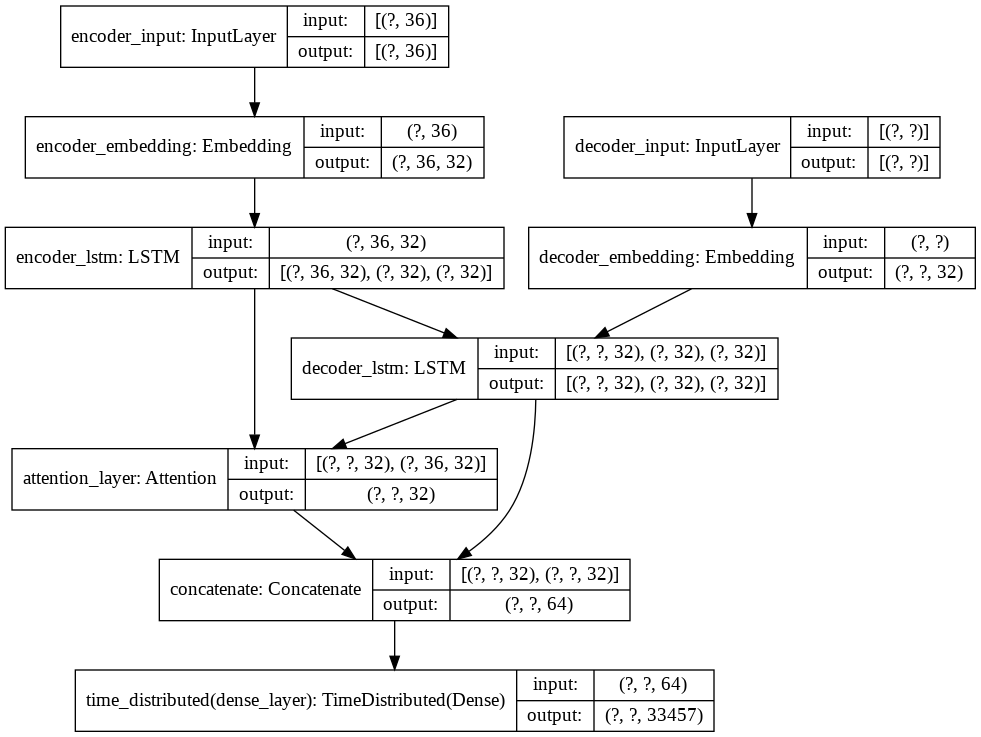

In [6]:
plot_model(attention_model, to_file='attention_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
#encoder_model
encoder_input = attention_model.input[0] # input_1
encoder_embedding_layer = attention_model.layers[2]
encoder_embedding = encoder_embedding_layer(encoder_input)
encoder_lstm = attention_model.layers[4]
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_state = [state_h, state_c]
encoder_model = Model(encoder_input, [encoder_output] + encoder_state)

In [7]:
encoder_model.save('attention_encoder.h5')

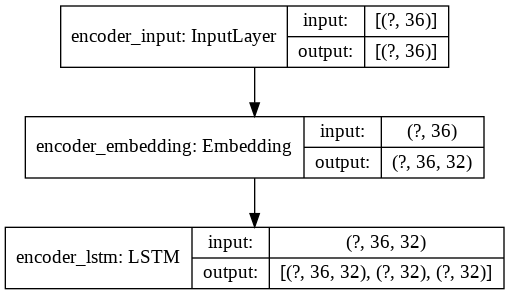

In [7]:
plot_model(encoder_model, to_file='att_encoder_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
#decoder_output
decoder_input = attention_model.input[1]
decoder_state_h_input = Input(shape = (32,))
decoder_state_c_input = Input(shape = (32,))
decoder_state_input = [decoder_state_h_input, decoder_state_c_input]
decoder_embedding_layer = attention_model.layers[3]
decoder_embedding = decoder_embedding_layer(decoder_input)


decoder_lstm = attention_model.layers[5]
decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding, initial_state = decoder_state_input)
decoder_state = [decoder_state_h, decoder_state_c]

attention_input = Input(shape = (36,32,))
attention_layer = attention_model.layers[6]
attention_output = attention_layer([decoder_output, attention_input])

concat_layer = attention_model.layers[7]
concat_output = concat_layer([decoder_output, attention_output])


dense_layer = attention_model.layers[8]
dense_output = dense_layer(concat_output)

decoder_model = Model([decoder_input] + decoder_state_input + [attention_input],[dense_output] + decoder_state)

In [9]:
decoder_model.save('attention_decoder.h5')

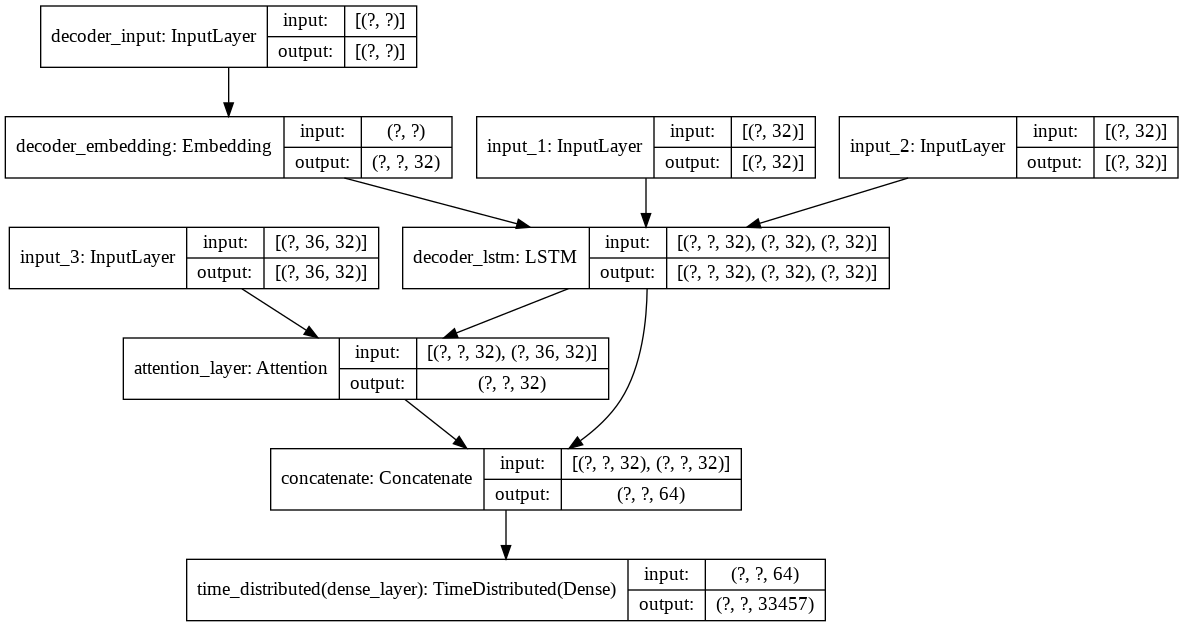

In [9]:
plot_model(decoder_model, to_file='att_decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def Attention_inference_beam(question, beam_size):
    
    """ Function Take question and give answer"""
    
    question = pd.DataFrame([question])
    question = question[0]
    question = que.texts_to_sequences(question)
    question = pad_sequences(question, padding = 'post', maxlen = 36)
    
    
    question = question.reshape(-1, 36)
    
    encoder_output, state_h, state_c = encoder_model.predict(question)
    encoder_state = [state_h, state_c]
    
    target_word=np.zeros((1,1))
    # <end>:1, <start>:2 
    target_word[0,0] = 2
    k = 0
    lst_sent_index = [[[2], 0.0]]
    stop_condition = False
    
    while not stop_condition:
        temp = []
        for s in lst_sent_index:
            
            output, state_h, state_c = decoder_model.predict([target_word] + encoder_state +[encoder_output])
            encoder_state = [state_h,state_c]
            
            word_preds = np.argsort(output[0][0])[-beam_size:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(output[0][0][w])
                temp.append([next_cap, prob])
            
        lst_sent_index = temp
        lst_sent_index = sorted(lst_sent_index, reverse=False, key=lambda l: l[1])
    
        lst_sent_index = lst_sent_index[-beam_size:]
    
        top_proba = lst_sent_index[-1] # with Max Probability
        
        k+=1
        if top_proba[0][-1] == 1 or k ==10:
            stop_condition=True
            
        target_word = np.zeros((1,1))
        target_word[0,0] = top_proba[0][-1]
    
    lst_sent_index = sorted(lst_sent_index, reverse = True, key = lambda l: l[1])
    
    lst_sent = []
    for ele in lst_sent_index:
        sent = ''
        for i in range(1, len(ele[0])):
            if ele[0][i] != 1:
                sent = sent + ' ' + ans_index_word[int(ele[0][i])]
        lst_sent.append(sent)
    
    return lst_sent

In [ ]:
print('question:', x_train.values[18])
print("="*50)
print('Actual_answer:', y_train['decoder_output'].values[18])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_train.values[18], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: answering machine give date time call mute reduce volume zero incoming messages left
Actual_answer: yes <end>
Predicted_answer:
Response 1:  yes
Response 2:  no


In [ ]:
print('question:', x_train.values[112])
print("="*50)
print('Actual_answer:', y_train['decoder_output'].values[112])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_train.values[112], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: vacuum manufactured site states vacuums made usa not say one
Actual_answer: it is made in china <end>
Predicted_answer:
Response 1:  yes is made in china
Response 2:  it is made in china


In [ ]:
print('question:', x_train.values[200])
print("="*50)
print('Actual_answer:', y_train['decoder_output'].values[200])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_train.values[200], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: wide bassinet
Actual_answer: product dimensions 34 5 x 20 x 35 8 inches 27 pounds <end>
Predicted_answer:
Response 1:  the seat is about wide
Response 2:  the seat is not wide


In [ ]:
print('question:', x_test.values[1])
print("="*50)
print('Actual_answer:', y_test['decoder_output'].values[1])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_test.values[1], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: come 8 pieces per size
Actual_answer: the order i received was all one size <end>
Predicted_answer:
Response 1:  it comes a pack
Response 2:  the is a pack


In [ ]:
print('question:', x_test.values[1002])
print("="*50)
print('Actual_answer:', y_test['decoder_output'].values[1002])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_test.values[1002], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: recently purchased really like noticing sensor attached magents moves tilts slightly anyone experience
Actual_answer: i have not <end>
Predicted_answer:
Response 1:  yes it does
Response 2:  no it does


In [ ]:
print('question:', x_test.values[199])
print("="*50)
print('Actual_answer:', y_test['decoder_output'].values[199])
print("="*50)
print('Predicted_answer:')
sent1, sent2 = Attention_inference_beam(x_test.values[199], 2)
print('Response 1:', sent1)
print('Response 2:', sent2)

question: size woofer
Actual_answer: it is 5 http www fluance com product sx6 high definition two way bookshelf loudspeakers eng 12 html <end>
Predicted_answer:
Response 1:  the dimensions are 1 2 x 8
Response 2:  the dimensions are 1 2 x 5


## 4. Metric: Bleu Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
def bleu_score(question, answer):
    
    """ Function take actual answer and return BLEU score"""

    actual_answer = []
    predicted_answer = []

    for i in tqdm(range(len(question))):
        pred_answer = Attention_inference_beam(question.values[i], 1)
        predicted_answer.append(pred_answer[0].split())
        lw = answer.values[i].split()
        lw.remove('<end>')
        actual_answer.append(lw)

        
    print('BLEU-Score 1-gram:',corpus_bleu(actual_answer, predicted_answer, weights=(1, 0, 0, 0)))
    print('BLEU-Score 2-gram:',corpus_bleu(actual_answer, predicted_answer, weights=(0, 1, 0, 0)))
    print('BLEU-Score 3-gram:',corpus_bleu(actual_answer, predicted_answer, weights=(0, 0, 1, 0)))
    print('BLEU-Score 4-gram:',corpus_bleu(actual_answer, predicted_answer, weights=(0, 0, 0, 1)))

In [ ]:
print('Bleu Score of train_data:')
bleu_score(x_train[:10000], y_train['decoder_output'][:10000])#using only 10k data. we can also use whole data but it take many time

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Bleu Score of train_data:


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [28:08<00:00,  5.92it/s]


BLEU-Score 1-gram: 0.20835087719298245
BLEU-Score 2-gram: 0.08040816326530612
BLEU-Score 3-gram: 3.19488817891374e-05
BLEU-Score 4-gram: 2.2250738585072626e-308


In [ ]:
print('Bleu Score of test_data:')
bleu_score(x_test[:5000], y_test['decoder_output'][:5000])#using only 5k data

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Bleu Score of test_data:


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:40<00:00,  5.68it/s]


BLEU-Score 1-gram: 0.18105954944096783
BLEU-Score 2-gram: 0.07240816326530612
BLEU-Score 3-gram: 6.24921884764404e-05
BLEU-Score 4-gram: 2.2250738585072626e-308


## 5. Compare: BLEU Score

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Data", "1-gram", "2-gram", "3-gram", "4-gram"]
x.add_row(["ED", "train", 0.10419256402490253, 0.0010019246762979967, 2.177635336818186e-308, 2.177635336818186e-308])
x.add_row(["ED", "test", 0.10380434782608695, 0.0013530443497870206, 6.15991129727732e-05, 2.2250738585072626e-308])
x.add_row(["Attention", "train", 0.20835087719298245, 0.08040816326530612, 3.19488817891374e-05, 2.2250738585072626e-308])
x.add_row(["Attention", "test", 0.18105954944096783, 0.07240816326530612, 6.24921884764404e-05, 2.2250738585072626e-308])

print(x)

+-----------+-------+---------------------+-----------------------+------------------------+-------------------------+
|   Model   |  Data |        1-gram       |         2-gram        |         3-gram         |          4-gram         |
+-----------+-------+---------------------+-----------------------+------------------------+-------------------------+
|     ED    | train | 0.10419256402490253 | 0.0010019246762979967 | 2.177635336818186e-308 |  2.177635336818186e-308 |
|     ED    |  test | 0.10380434782608695 | 0.0013530443497870206 |  6.15991129727732e-05  | 2.2250738585072626e-308 |
| Attention | train | 0.20835087719298245 |  0.08040816326530612  |  3.19488817891374e-05  | 2.2250738585072626e-308 |
| Attention |  test | 0.18105954944096783 |  0.07240816326530612  |  6.24921884764404e-05  | 2.2250738585072626e-308 |
+-----------+-------+---------------------+-----------------------+------------------------+-------------------------+
